In [30]:
import os 
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image 
import pathlib


import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from torch import nn
from torchinfo import summary


from typing import Tuple, Dict, List


In [2]:
data_address = "train"

## **plot some image with classes**

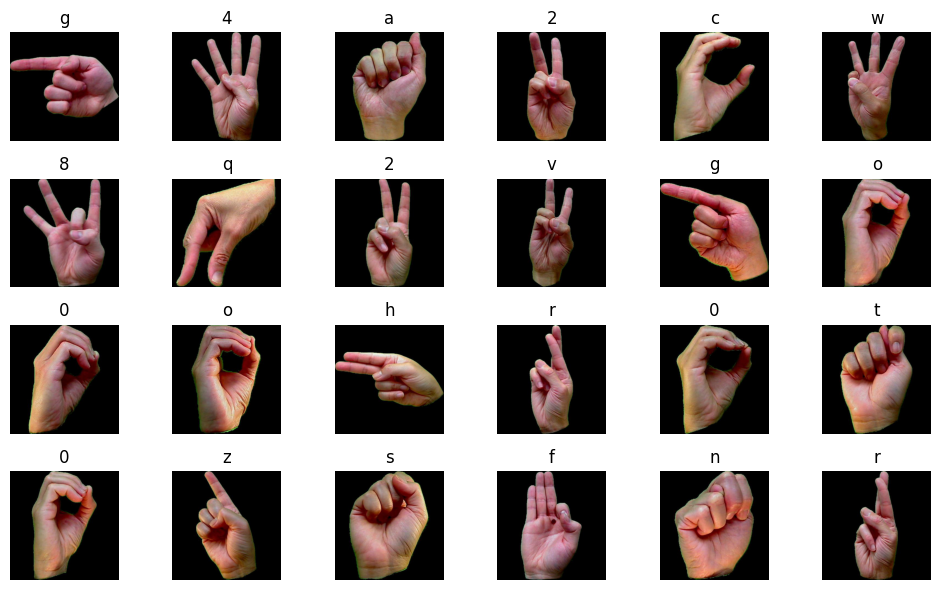

In [3]:
plt.figure(figsize=(10,6))
for i in range(24):
    plt.subplot(4,6,i+1)
    sub_class = random.choice(os.listdir(data_address))
    sub_path = os.path.join(data_address,sub_class)
    sub_image = random.choice(os.listdir(sub_path))
    img = Image.open(os.path.join(sub_path,sub_image))

    plt.imshow(img)
    plt.title(sub_class)
    plt.axis("off")
plt.tight_layout()

## **add transform and plot them**

In [15]:
data_transform_train = transforms.Compose([
    transforms.RandomEqualize(p=0.25),
    # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.RandomRotation(degrees=(-20, 20)),
    # transforms.ElasticTransform(alpha=100.0),
    # transforms.ColorJitter(brightness=.5, hue=.3),
    # transforms.RandomResizedCrop(size=(300, 300)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    transforms.Resize(size=(256, 256)),
    # transforms.RandomPosterize(bits=2),
    transforms.ToTensor()
])

data_transform_test = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])



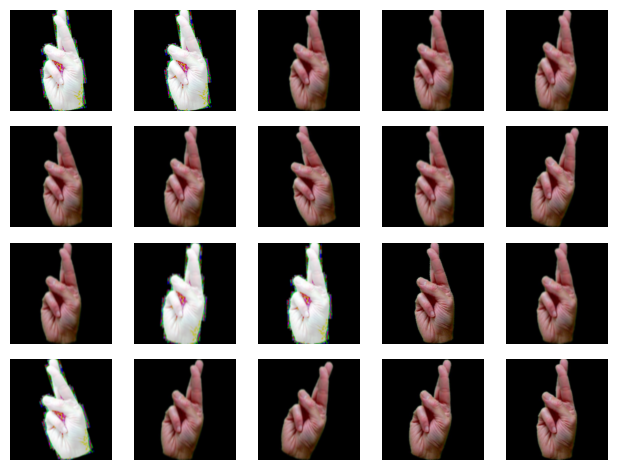

In [16]:
transformed_image = [data_transform_train(img) for i in range(20)]

for index, image in enumerate(transformed_image):
    plt.subplot(4,5,index+1)

    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")
plt.tight_layout()

## **Custom DataLoader**

> find class for directory

In [10]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
find_classes(data_address)

In [14]:
class ASLDataset(Dataset):
    def __init__(self,
                 target_dir:str,
                 transform=None) -> None:
        
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpeg")) # note: you'd have to update this if you've got .png's or .jpeg's
        self.transform = transform        
        self.classes, self.classes_to_idx = find_classes(target_dir)
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.laod_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.classes_to_idx[class_name]        
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx
    
    def laod_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

In [17]:
train_path = "train"
test_path = "test"

train_data = ASLDataset(target_dir=train_path,
                                  transform=data_transform_train)

test_data =  ASLDataset(target_dir=test_path,
                                  transform=data_transform_test)


In [22]:
BATCH_SIZE = 8
# for windows must be zero
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1a9b78a3b88>,
 <torch.utils.data.dataloader.DataLoader at 0x1a9b78a3ac8>)

In [21]:
print(len(test_data))
test_data[0]

252


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [42]:
class TinyVGG(nn.Module):
    def __init__(self,input_shape:int,
                 hidden_unit:int,
                 output_shape:int
                 ) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_unit,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,out_channels=hidden_unit,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_unit,hidden_unit,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_unit,hidden_unit,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_unit*64*64,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

        

get device name 

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### **create model**

In [44]:
model = TinyVGG(input_shape=3,
                  hidden_unit=10, 
                  output_shape=len(train_data.classes)).to(device)
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=40960, out_features=36, bias=True)
  )
)

In [46]:
# for better summary
summary(model, input_size=[1, 3,256, 256])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 36]                   --
├─Sequential: 1-1                        [1, 10, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 10, 256, 256]         280
│    └─ReLU: 2-2                         [1, 10, 256, 256]         --
│    └─Conv2d: 2-3                       [1, 10, 256, 256]         910
│    └─ReLU: 2-4                         [1, 10, 256, 256]         --
│    └─MaxPool2d: 2-5                    [1, 10, 128, 128]         --
├─Sequential: 1-2                        [1, 10, 64, 64]           --
│    └─Conv2d: 2-6                       [1, 10, 128, 128]         910
│    └─ReLU: 2-7                         [1, 10, 128, 128]         --
│    └─Conv2d: 2-8                       [1, 10, 128, 128]         910
│    └─ReLU: 2-9                         [1, 10, 128, 128]         --
│    └─MaxPool2d: 2-10                   [1, 10, 64, 64]           --
├─Sequentia

In [28]:
image_batch, label_batch = next(iter(train_dataloader))

In [29]:
image_batch.shape

torch.Size([8, 3, 256, 256])

train and test step

In [47]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn :torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    model.train()

    train_loss,train_acc = 0,0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device),y.to(device)
    
        y_pred = model(X)

        loss = loss_fn(y_pred,y)
        train_loss += loss.item()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss,train_acc

In [50]:
def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn :torch.nn.Module,
               device=device):
    
    model.eval()
    test_loss, test_acc = 0,0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device),y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred,y)
        test_loss += loss.item()

        test_label = y_pred.argmax(dim=1)
        test_acc += (test_label == y).sum().item()/len(test_label)
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss,test_acc

In [48]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [51]:
NUM_EPOCHS = 10

model = TinyVGG(input_shape=3, 
                  hidden_unit=10, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [01:36<14:31, 96.86s/it]

Epoch: 1 | train_loss: 1.9393 | train_acc: 0.4658 | test_loss: 0.8942 | test_acc: 0.7188


 20%|██        | 2/10 [03:12<12:50, 96.26s/it]

Epoch: 2 | train_loss: 0.8393 | train_acc: 0.7480 | test_loss: 0.5640 | test_acc: 0.7969


 30%|███       | 3/10 [04:50<11:19, 97.01s/it]

Epoch: 3 | train_loss: 0.6092 | train_acc: 0.8157 | test_loss: 0.3837 | test_acc: 0.9141


 40%|████      | 4/10 [06:30<09:48, 98.00s/it]

Epoch: 4 | train_loss: 0.4256 | train_acc: 0.8679 | test_loss: 0.4427 | test_acc: 0.8750


 50%|█████     | 5/10 [08:09<08:13, 98.63s/it]

Epoch: 5 | train_loss: 0.3431 | train_acc: 0.8905 | test_loss: 0.4824 | test_acc: 0.8203


 60%|██████    | 6/10 [09:49<06:35, 98.96s/it]

Epoch: 6 | train_loss: 0.2919 | train_acc: 0.9041 | test_loss: 0.3334 | test_acc: 0.8789


 70%|███████   | 7/10 [11:29<04:57, 99.24s/it]

Epoch: 7 | train_loss: 0.2335 | train_acc: 0.9271 | test_loss: 0.3588 | test_acc: 0.8906


 80%|████████  | 8/10 [13:08<03:18, 99.21s/it]

Epoch: 8 | train_loss: 0.2172 | train_acc: 0.9298 | test_loss: 0.3052 | test_acc: 0.9023


 90%|█████████ | 9/10 [14:56<01:41, 101.93s/it]

Epoch: 9 | train_loss: 0.2015 | train_acc: 0.9301 | test_loss: 0.3064 | test_acc: 0.9102


100%|██████████| 10/10 [16:38<00:00, 99.84s/it] 

Epoch: 10 | train_loss: 0.1887 | train_acc: 0.9364 | test_loss: 0.2935 | test_acc: 0.9297
Total training time: 998.355 seconds


In [52]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

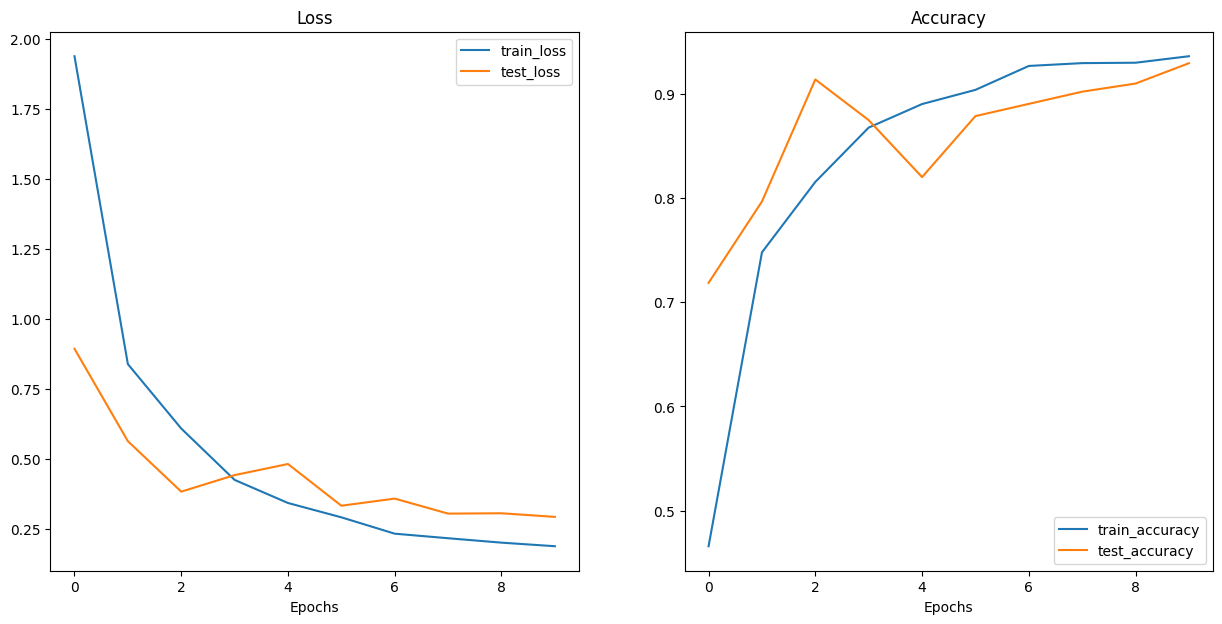

In [53]:
plot_loss_curves(model_0_results)